# **1. Import Library**

Mengimport library yang dibutuhkan

In [1]:
!"{sys.executable}" -m pip install matplotlib-venn

/bin/bash: line 1: {sys.executable}: command not found


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from sklearn.manifold import TSNE
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from wordcloud import WordCloud

2025-04-14 20:14:35.411803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744636478.317679  155738 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744636479.107346  155738 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744636486.092650  155738 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744636486.092712  155738 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744636486.092718  155738 computation_placer.cc:177] computation placer alr

# **2. Load Dataset**

Membaca dataset ratings.

In [3]:
ratings = pd.read_csv('ratings.csv')

Menampilkan sample data

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# **3. Data Wrangling**

Mengecek apakah ada missing value

In [5]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

# **4. EDA**

Melihat distribusi data pada fitur rating

/tmp/ipykernel_155738/2284662185.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


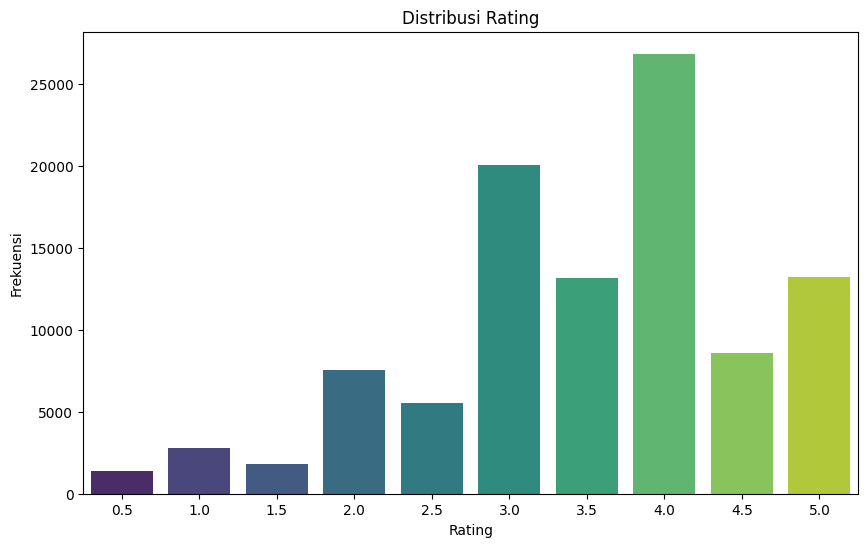

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

Melihat histogram dari fitur rating

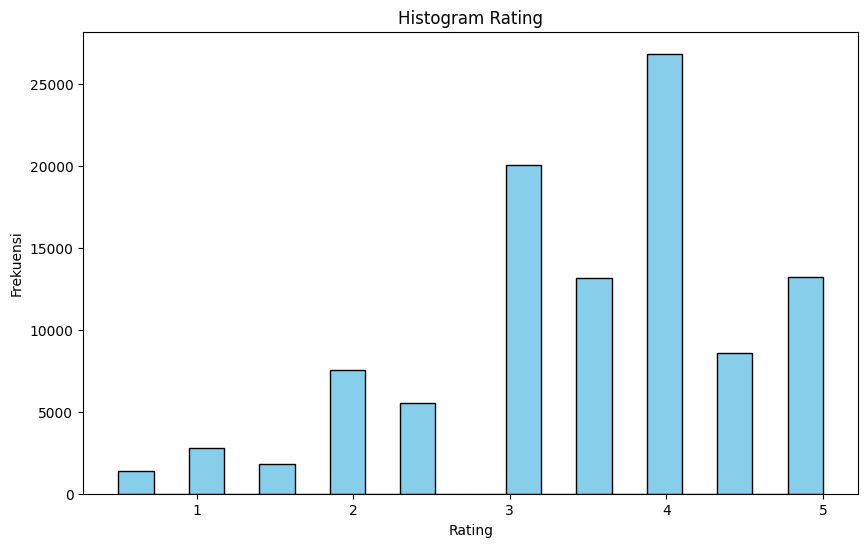

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(ratings['rating'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

Memvisualisasi fitur rating dengan boxplot untuk melihat korelasi atau insight lain.

/tmp/ipykernel_155738/1358547466.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', data=ratings, palette='viridis')


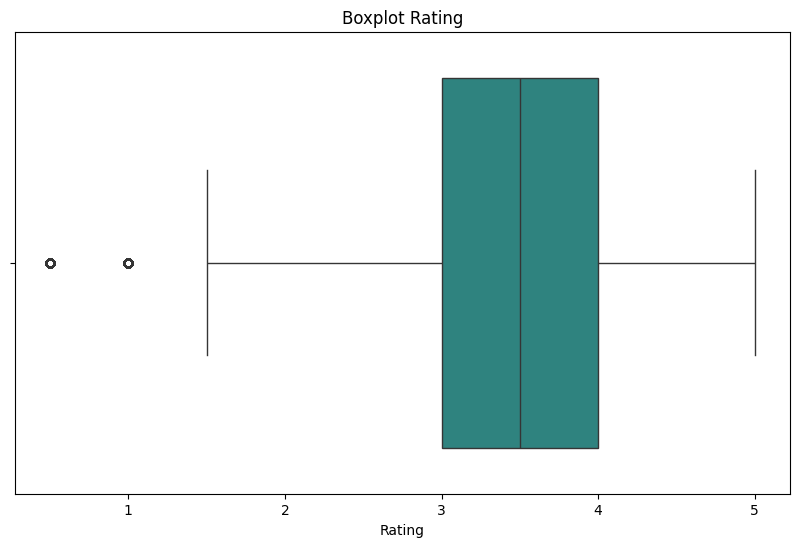

In [8]:
plt.figure(figsize=(10,6))
sns.boxplot(x='rating', data=ratings, palette='viridis')
plt.title('Boxplot Rating')
plt.xlabel('Rating')
plt.show()

# **4. Data Preparation**

Mengambil daftar unik user dan movie

In [9]:
user_ids = ratings['userId'].unique().tolist()
movie_ids = ratings['movieId'].unique().tolist()

Membuat dictionary untuk mapping userId dan movieId ke integer

In [10]:
user_to_index = {x: i for i, x in enumerate(user_ids)}
index_to_user = {i: x for i, x in enumerate(user_ids)}

movie_to_index = {x: i for i, x in enumerate(movie_ids)}
index_to_movie = {i: x for i, x in enumerate(movie_ids)}

Mapping ke dataframe

In [11]:
ratings['user'] = ratings['userId'].map(user_to_index)
ratings['movie'] = ratings['movieId'].map(movie_to_index)

Mengambil nilai min dan max dari rating

In [12]:
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()

Normalisasi rating ke skala 0-1

In [13]:
ratings['rating_norm'] = ratings['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

Mendeklarasikan kolom fitur dan target

In [14]:
# Input: kolom 'user' dan 'movie'
x = ratings[['user', 'movie']].values

# Target: rating yang sudah dinormalisasi
y = ratings['rating_norm'].values

# **5. Data Splitting**

Mengacak data

In [15]:
ratings = ratings.sample(frac=1, random_state=42)
x = ratings[['user', 'movie']].values
y = ratings['rating_norm'].values

Membagi ke training dan validasi


In [16]:
train_size = int(0.8 * len(ratings))
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

print("Jumlah data training:", x_train.shape[0])
print("Jumlah data validasi:", x_val.shape[0])

Jumlah data training: 80668
Jumlah data validasi: 20168


# **6. Model Building**

## 6.1. RecommenderNet

Melakukan model building dengan RecommenderNet dan Mengkompilasi model dengan Binary Crossentropy dan menggunakan optimizer Adam serta metric RMSE.

In [17]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        # Embedding untuk user
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        
        # Embedding untuk movie
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        
        # Dot product antara user dan movie embedding
        dot_user_movie = tf.reduce_sum(user_vector * movie_vector, axis=1, keepdims=True)
        
        # Menambahkan bias
        x = dot_user_movie + user_bias + movie_bias
        
        # Aktivasi sigmoid untuk output antara 0 dan 1
        return tf.nn.sigmoid(x)

num_users = len(user_to_index)
num_movies = len(movie_to_index)
embedding_size = 20

model = RecommenderNet(
    num_users, 
    num_movies, 
    embedding_size
)

model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

W0000 00:00:1744636631.950108  155738 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 6.2. NeuMF

In [18]:
def get_NeuMF_model(num_users, num_items, mf_dim=8, mlp_layers=[64,32,16,8], dropout=0.0):
    # Input layer
    user_input = Input(shape=(1,), name="user_input")
    item_input = Input(shape=(1,), name="item_input")

    # MF part embedding: gunakan embedding dimensi mf_dim
    mf_user_embedding = layers.Embedding(num_users, mf_dim, name="mf_user_embedding")(user_input)
    mf_item_embedding = layers.Embedding(num_items, mf_dim, name="mf_item_embedding")(item_input)
    mf_user_embedding = layers.Flatten()(mf_user_embedding)
    mf_item_embedding = layers.Flatten()(mf_item_embedding)
    mf_vector = layers.multiply([mf_user_embedding, mf_item_embedding])

    # MLP part embedding: gunakan ukuran embedding = mlp_layers[0]//2 agar jumlah dimensi tepat saat digabung
    mlp_embedding_dim = mlp_layers[0] // 2
    mlp_user_embedding = layers.Embedding(num_users, mlp_embedding_dim, name="mlp_user_embedding")(user_input)
    mlp_item_embedding = layers.Embedding(num_items, mlp_embedding_dim, name="mlp_item_embedding")(item_input)
    mlp_user_embedding = layers.Flatten()(mlp_user_embedding)
    mlp_item_embedding = layers.Flatten()(mlp_item_embedding)
    mlp_vector = layers.concatenate([mlp_user_embedding, mlp_item_embedding])
    
    # MLP layers
    for idx, units in enumerate(mlp_layers[1:]):
        mlp_vector = layers.Dense(units, activation='relu', name=f"mlp_dense_{idx}")(mlp_vector)
        if dropout > 0:
            mlp_vector = layers.Dropout(dropout)(mlp_vector)
    
    # Concatenate MF and MLP parts
    neumf_vector = layers.concatenate([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = layers.Dense(1, activation="sigmoid", name="prediction")(neumf_vector)
    
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    return model

# Inisialisasi NeuMF:
num_users = len(user_to_index)
num_items = len(movie_to_index)

neuMF_model = get_NeuMF_model(
    num_users, num_items, 
    mf_dim=8, 
    mlp_layers=[64,32,16,8]
)

neuMF_model.compile(
    loss='mean_squared_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# **7. Model Training**

Menerapkan Callbacks early stoping untuk menghentikan model ketika val_loss tidak berkurang selama 3 epoch dan merestore kembali weight yang terbaik.

In [19]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

## 7.1. RecommenderNet

Melatih model RecommenderNet.

In [20]:
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0690 - root_mean_squared_error: 0.2621 - val_loss: 0.0430 - val_root_mean_squared_error: 0.2057 - learning_rate: 0.0010
Epoch 2/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0380 - root_mean_squared_error: 0.1926 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1930 - learning_rate: 0.0010
Epoch 3/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0320 - root_mean_squared_error: 0.1746 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1895 - learning_rate: 0.0010
Epoch 4/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0284 - root_mean_squared_error: 0.1627 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1887 - learning_rate: 0.0010
Epoch 5/20
2514/2521 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0255 - root_mean_squared_error: 0.1520
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0255 - root_mean_squared_er

## 7.2. NeuMF

Melatih model NeuMF.

In [21]:
history_neuMF = neuMF_model.fit(
    [x_train[:,0], x_train[:,1]], y_train, 
    batch_size=32, 
    epochs=20, 
    validation_data=([x_val[:,0], x_val[:,1]], y_val),
    callbacks=callbacks
    )

Epoch 1/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0454 - root_mean_squared_error: 0.2124 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1938 - learning_rate: 0.0010
Epoch 2/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0326 - root_mean_squared_error: 0.1806 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1930 - learning_rate: 0.0010
Epoch 3/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0253 - root_mean_squared_error: 0.1591 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1988 - learning_rate: 0.0010
Epoch 4/20
2518/2521 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0411 - val_root_mean_squared_error: 0.2026 - learning_rate: 0.0010
Epoch 5/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0156 - root_mean_squared_er

# **8. Model Evaluation**

## 8.1. Plot History Training

Membandingkan dua model rekomendasi, RecommenderNet dan NeuMF, dengan menampilkan grafik yang menunjukkan bagaimana loss dan RMSE berubah selama pelatihan.

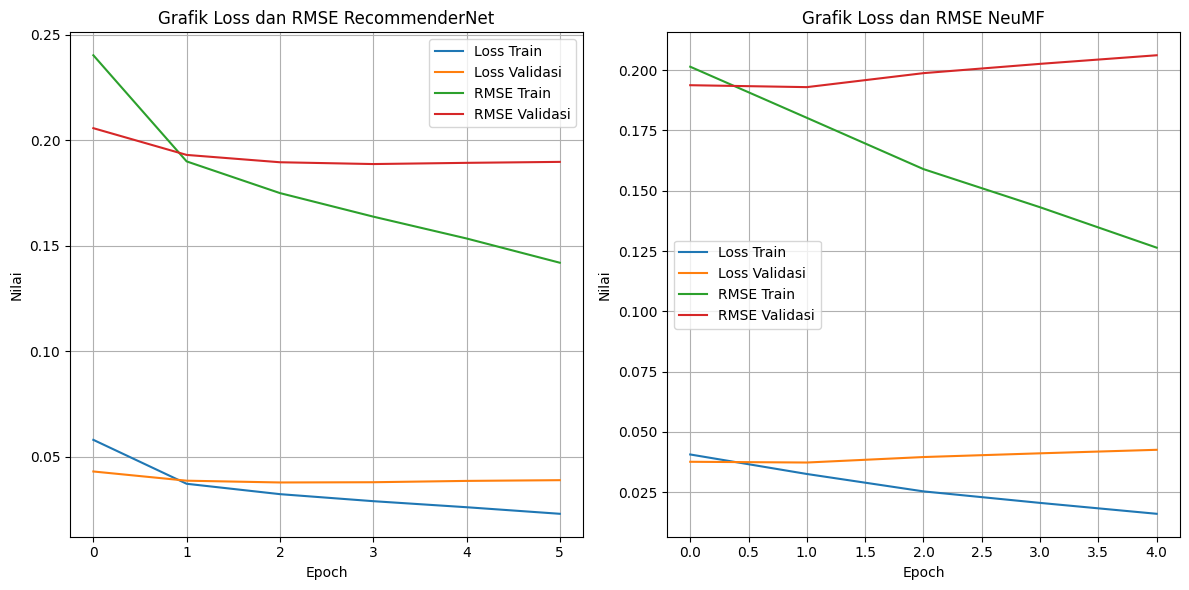

In [22]:
# Membuat figure dan axes untuk dua plot berdampingan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot pertama (RecommenderNet)
ax1.plot(history.history['loss'], label='Loss Train')
ax1.plot(history.history['val_loss'], label='Loss Validasi')
ax1.plot(history.history['root_mean_squared_error'], label='RMSE Train')
ax1.plot(history.history['val_root_mean_squared_error'], label='RMSE Validasi')
ax1.set_title('Grafik Loss dan RMSE RecommenderNet')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Nilai')
ax1.legend()
ax1.grid(True)

# Plot kedua (NeuMF)
ax2.plot(history_neuMF.history['loss'], label='Loss Train')
ax2.plot(history_neuMF.history['val_loss'], label='Loss Validasi')
ax2.plot(history_neuMF.history['root_mean_squared_error'], label='RMSE Train')
ax2.plot(history_neuMF.history['val_root_mean_squared_error'], label='RMSE Validasi')
ax2.set_title('Grafik Loss dan RMSE NeuMF')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Nilai')
ax2.legend()
ax2.grid(True)

# Menampilkan plot
plt.tight_layout()
plt.show()

## 8.2. Metrik Error (RMSE, MAE, R²)

Membandingkan kinerja dua model rekomendasi, RecommenderNet dan NeuMF, dengan menghitung beberapa metrik evaluasi seperti RMSE, MAE, dan R².

In [23]:
# Prediksi dan rescaling untuk model RecommenderNet
y_pred = model.predict(x_val).flatten()
y_pred_rescaled = y_pred * (max_rating - min_rating) + min_rating
y_val_rescaled = y_val * (max_rating - min_rating) + min_rating

mse_recommender = mean_squared_error(y_val_rescaled, y_pred_rescaled)
rmse_recommender = np.sqrt(mse_recommender)
mae_recommender = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
r2_recommender = r2_score(y_val_rescaled, y_pred_rescaled)

# Prediksi dan rescaling untuk model NeuMF
user_input = x_val[:, 0]
movie_input = x_val[:, 1]
y_pred_neuMF = neuMF_model.predict([user_input, movie_input]).flatten()

y_pred_rescaled_neuMF = y_pred_neuMF * (max_rating - min_rating) + min_rating
y_val_rescaled_neuMF = y_val * (max_rating - min_rating) + min_rating

mse_neuMF = mean_squared_error(y_val_rescaled_neuMF, y_pred_rescaled_neuMF)
rmse_neuMF = np.sqrt(mse_neuMF)
mae_neuMF = mean_absolute_error(y_val_rescaled_neuMF, y_pred_rescaled_neuMF)
r2_neuMF = r2_score(y_val_rescaled_neuMF, y_pred_rescaled_neuMF)

# Membuat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "R²"],
    "RecommenderNet": [rmse_recommender, mae_recommender, r2_recommender],
    "NeuMF": [rmse_neuMF, mae_neuMF, r2_neuMF]
})

print(comparison_df)


631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
  Metric  RecommenderNet     NeuMF
0   RMSE        0.852943  0.868458
1    MAE        0.659185  0.665995
2     R²        0.333304  0.308830


## 8.3. Scatterplot : Actual Rating vs Predicted Rating

Membandingkan hasil prediksi rating dari dua model rekomendasi, RecommenderNet dan NeuMF, dengan menggunakan scatter plot. Garis merah pada kedua plot menunjukkan garis referensi di mana prediksi dan rating sebenarnya akan saling bertemu. Hal ini dapat membantu melihat seberapa akurat prediksi masing-masing model dibandingkan dengan rating yang sebenarnya.

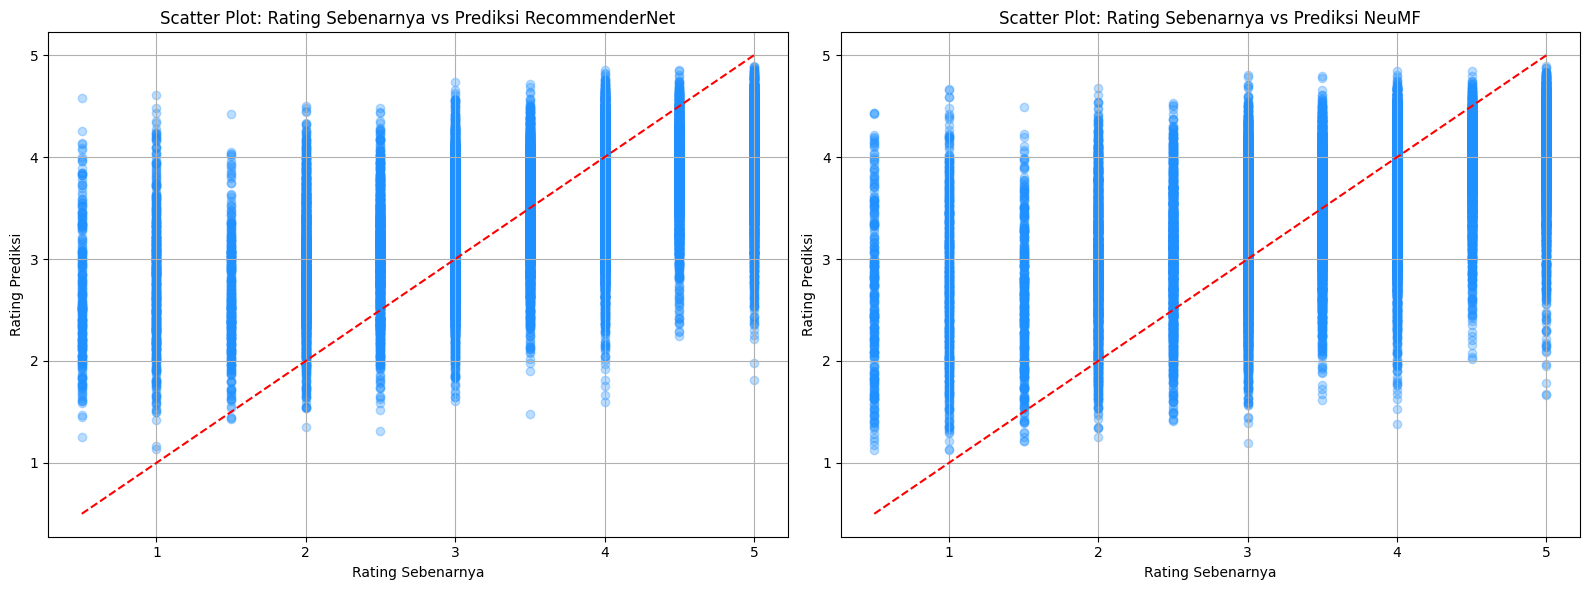

In [24]:
# Membuat figure dan axes untuk dua scatter plot berdampingan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot pertama (RecommenderNet)
ax1.scatter(y_val_rescaled, y_pred_rescaled, alpha=0.3, color='dodgerblue')
ax1.plot([min_rating, max_rating], [min_rating, max_rating], color='red', linestyle='--')
ax1.set_xlabel('Rating Sebenarnya')
ax1.set_ylabel('Rating Prediksi')
ax1.set_title('Scatter Plot: Rating Sebenarnya vs Prediksi RecommenderNet')
ax1.grid(True)

# Plot kedua (NeuMF)
ax2.scatter(y_val_rescaled_neuMF, y_pred_rescaled_neuMF, alpha=0.3, color='dodgerblue')
ax2.plot([min_rating, max_rating], [min_rating, max_rating], color='red', linestyle='--')
ax2.set_xlabel('Rating Sebenarnya')
ax2.set_ylabel('Rating Prediksi')
ax2.set_title('Scatter Plot: Rating Sebenarnya vs Prediksi NeuMF')
ax2.grid(True)

# Menampilkan plot
plt.tight_layout()
plt.show()

## 8.4. Top-N

Membandingkan rekomendasi film dari dua model, RecommenderNet dan NeuMF, berdasarkan prediksi yang dihasilkan oleh masing-masing model.

In [25]:
movies = pd.read_csv('/mnt/d/Artificial Intellegence/Machine Learning/CodingCamp/Proyek Machine Learning Terapan/Recommendation System/movies.csv')

# Fungsi untuk mendapatkan rekomendasi Top-N
def get_top_n_recommendations(user_id_asli, model, n=10, use_neumf=False):
    user_index = user_to_index[user_id_asli]
    all_movie_indices = np.array(list(index_to_movie.keys()))

    watched_movies = ratings[ratings['userId'] == user_id_asli]['movieId'].tolist()
    watched_indices = [movie_to_index[m] for m in watched_movies if m in movie_to_index]
    unwatched_indices = list(set(all_movie_indices) - set(watched_indices))

    user_input = np.full(len(unwatched_indices), user_index)

    if use_neumf:
        predictions = model.predict([user_input, np.array(unwatched_indices)], verbose=0).flatten()
    else:
        input_pairs = np.stack((user_input, np.array(unwatched_indices)), axis=1)
        predictions = model.predict(input_pairs, verbose=0).flatten()

    top_indices = np.argsort(predictions)[-n:][::-1]
    top_movie_indices = np.array(unwatched_indices)[top_indices]
    top_movie_ids = [index_to_movie[idx] for idx in top_movie_indices]

    top_movies_df = movies[movies['movieId'].isin(top_movie_ids)]
    top_movies_df = top_movies_df.copy()
    top_movies_df["Predicted Score"] = predictions[top_indices]  # tetap 0-1
    top_movies_df["Predicted Rating"] = top_movies_df["Predicted Score"] * (max_rating - min_rating) + min_rating
    top_movies_df = top_movies_df.sort_values(by="Predicted Score", ascending=False).reset_index(drop=True)

    top_movies_df["Rank"] = range(1, len(top_movies_df) + 1)
    return top_movies_df[["Rank", "title", "Predicted Score", "Predicted Rating"]]

# Mengambil rekomendasi dari model pertama (RecommenderNet)
top_n_rec_recommender = get_top_n_recommendations(1, model, n=10, use_neumf=False)

# Mengambil rekomendasi dari model kedua (NeuMF)
top_n_rec_neumf = get_top_n_recommendations(1, neuMF_model, n=10, use_neumf=True)

# Menambahkan kolom 'Model' untuk membedakan antara dua model
top_n_rec_recommender['Model'] = 'RecommenderNet'
top_n_rec_neumf['Model'] = 'NeuMF'

# Menggabungkan kedua DataFrame tanpa berdasarkan 'title'
top_n_combined = pd.concat([top_n_rec_recommender, top_n_rec_neumf], ignore_index=True)

# Menampilkan hasil gabungan
top_n_combined


,Rank,title,Predicted Score,Predicted Rating,Model
0,1,"Shawshank Redemption, The (1994)",0.980589,4.912650,RecommenderNet
1,2,"Godfather, The (1972)",0.977263,4.897682,RecommenderNet
2,3,Cinema Paradiso (Nuovo cinema Paradiso) (1989),0.970620,4.867788,RecommenderNet
3,4,12 Angry Men (1957),0.963130,4.834083,RecommenderNet
4,5,Lawrence of Arabia (1962),0.962036,4.829163,RecommenderNet
5,6,"Godfather: Part II, The (1974)",0.961696,4.827631,RecommenderNet
6,7,Patton (1970),0.961074,4.824835,RecommenderNet
7,8,Memento (2000),0.960709,4.823191,RecommenderNet
8,9,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",0.959818,4.819183,RecommenderNet
9,10,"Departed, The (2006)",0.959591,4.818161,RecommenderNet


Membandingkan rekomendasi film dari dua model, RecommenderNet dan NeuMF, dalam bentuk grafik horizontal yang menampilkan skor prediksi dari setiap film yang direkomendasikan oleh kedua model.

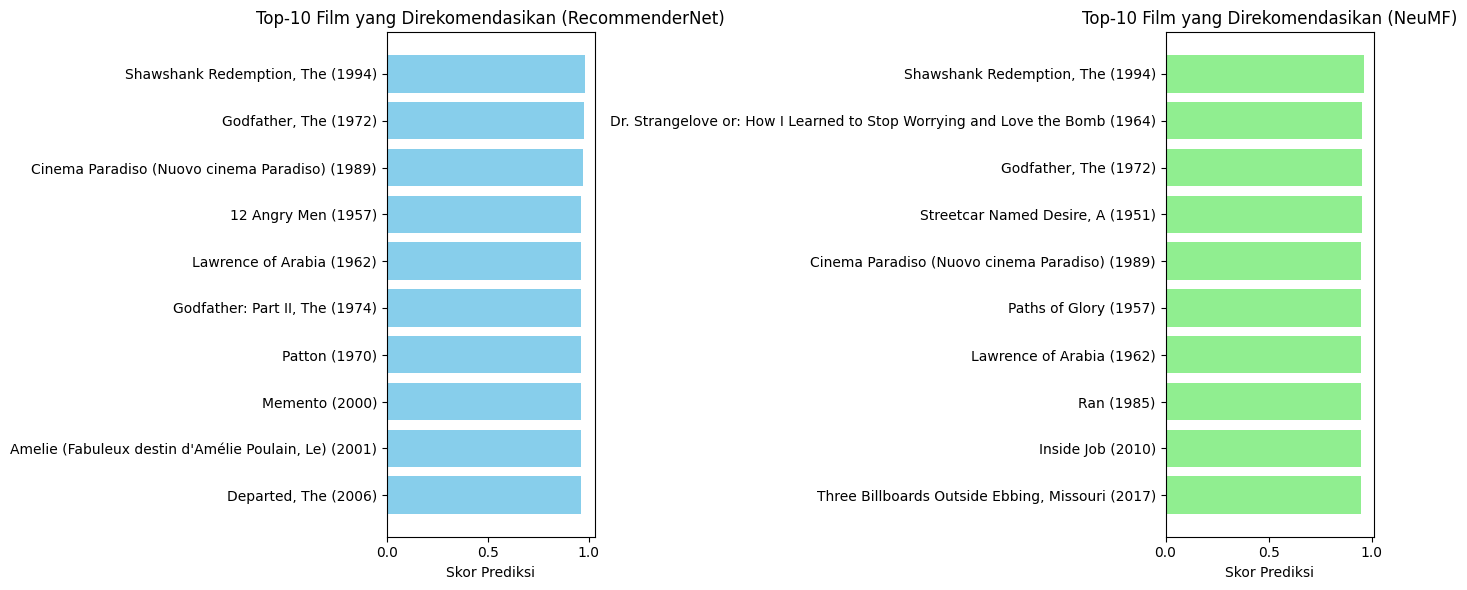

In [26]:
# Ambil skor dari hasil DataFrame untuk RecommenderNet
top_scores_recommender = top_n_rec_recommender['Predicted Score'].values
top_titles_recommender = top_n_rec_recommender['title'].values

# Ambil skor dari hasil DataFrame untuk NeuMF
top_scores_neumf = top_n_rec_neumf['Predicted Score'].values
top_titles_neumf = top_n_rec_neumf['title'].values

# Membuat sub-plot untuk perbandingan
plt.figure(figsize=(14, 6))

# Plot Top-10 rekomendasi RecommenderNet
plt.subplot(1, 2, 1)
plt.barh(top_titles_recommender, top_scores_recommender, color='skyblue')
plt.xlabel('Skor Prediksi')
plt.title('Top-10 Film yang Direkomendasikan (RecommenderNet)')
plt.gca().invert_yaxis()

# Plot Top-10 rekomendasi NeuMF
plt.subplot(1, 2, 2)
plt.barh(top_titles_neumf, top_scores_neumf, color='lightgreen')
plt.xlabel('Skor Prediksi')
plt.title('Top-10 Film yang Direkomendasikan (NeuMF)')
plt.gca().invert_yaxis()

# Menampilkan kedua plot
plt.tight_layout()
plt.show()

## 8.5. Visualisasi 2D Embedding

Membandingkan embedding film yang dihasilkan oleh dua model rekomendasi, RecommenderNet dan NeuMF, dengan memvisualisasikan hasil reduksi dimensi menggunakan t-SNE.

/mnt/d/Artificial Intellegence/Machine Learning/CodingCamp/Proyek Machine Learning Terapan/Recommendation System/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/mnt/d/Artificial Intellegence/Machine Learning/CodingCamp/Proyek Machine Learning Terapan/Recommendation System/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


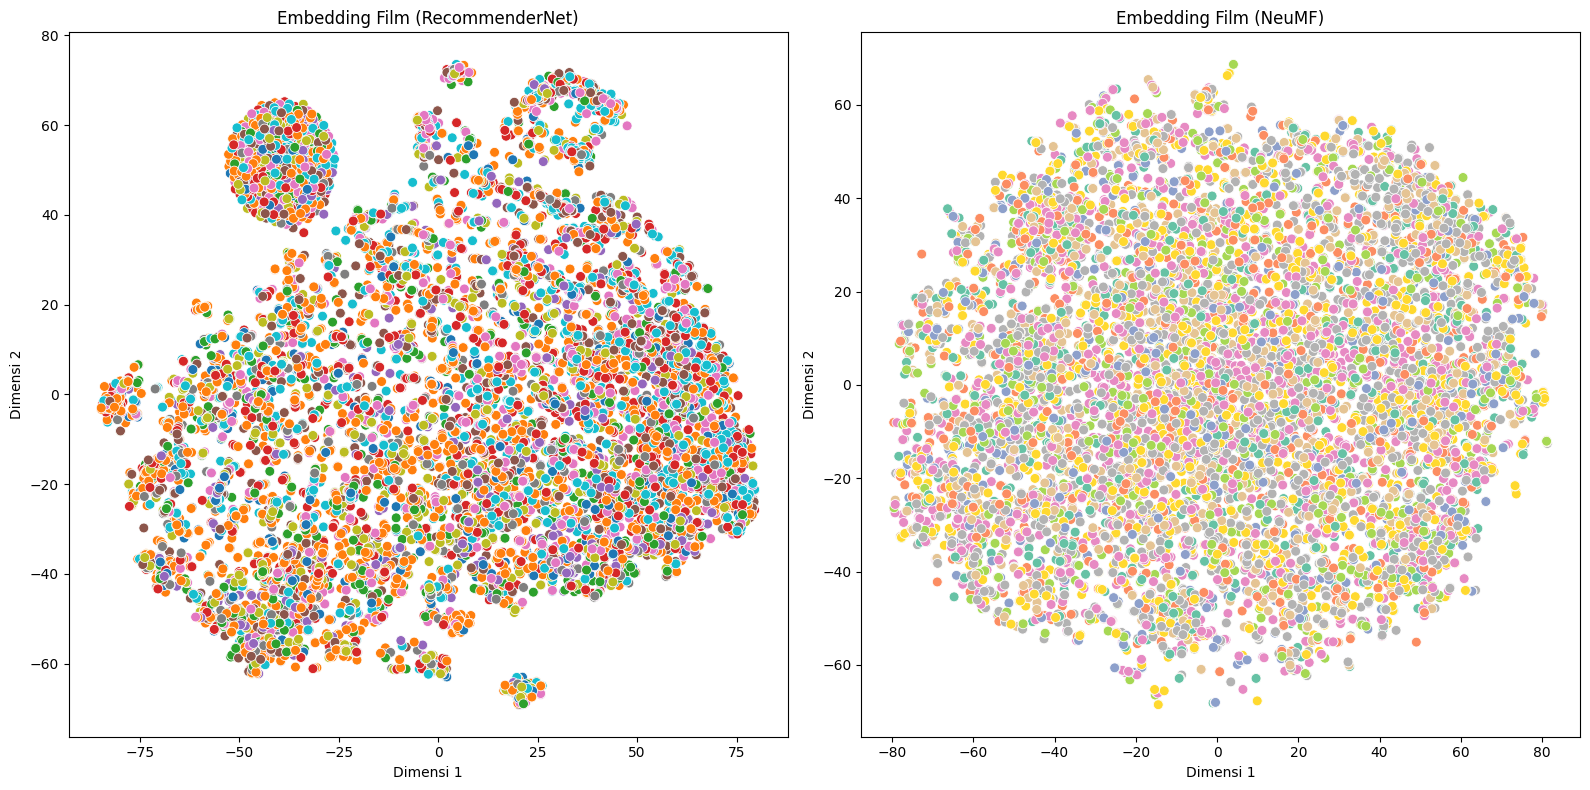

In [27]:
# Mengambil matriks embedding dari model pertama (RecommenderNet)
movie_embeddings_recommender = model.movie_embedding.get_weights()[0]  # bentuk: (num_movies, embedding_size)

# Reduksi dimensi ke 2D dengan t-SNE untuk model pertama
tsne_recommender = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
movie_embeddings_2d_recommender = tsne_recommender.fit_transform(movie_embeddings_recommender)

# DataFrame untuk plot model pertama
df_emb_recommender = pd.DataFrame(movie_embeddings_2d_recommender, columns=['x', 'y'])
df_emb_recommender['movie_index'] = np.arange(movie_embeddings_recommender.shape[0])

# Mengambil matriks embedding dari model kedua (NeuMF)
movie_embedding_layer_neumf = neuMF_model.get_layer("mf_item_embedding")
movie_embeddings_neumf = movie_embedding_layer_neumf.get_weights()[0]

# Reduksi dimensi ke 2D dengan t-SNE untuk model kedua
tsne_neumf = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
movie_embeddings_2d_neumf = tsne_neumf.fit_transform(movie_embeddings_neumf)

# DataFrame untuk plot model kedua
df_emb_neumf = pd.DataFrame(movie_embeddings_2d_neumf, columns=['x', 'y'])
df_emb_neumf['movie_index'] = np.arange(movie_embeddings_neumf.shape[0])

# Membaca data movie
movies = pd.read_csv('movies.csv')
movies['movie_index'] = movies['movieId'].map(movie_to_index)

# Menggabungkan data embedding dengan movie info untuk kedua model
df_plot_recommender = pd.merge(df_emb_recommender, movies, on='movie_index', how='left')
df_plot_neumf = pd.merge(df_emb_neumf, movies, on='movie_index', how='left')

# Membuat figure untuk visualisasi gabungan
plt.figure(figsize=(16, 8))

# Plot untuk model pertama (RecommenderNet) di subplot kiri
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_plot_recommender, x='x', y='y', hue='genres', palette='tab10', legend=False, s=50)
plt.title('Embedding Film (RecommenderNet)')
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')

# Plot untuk model kedua (NeuMF) di subplot kanan
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_plot_neumf, x='x', y='y', hue='genres', palette='Set2', legend=False, s=50)
plt.title('Embedding Film (NeuMF)')
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')

# Menampilkan plot
plt.tight_layout()
plt.show()

## 8.6. Venn Diagram

Membandingkan hasil rekomendasi dari dua model, RecommenderNet dan NeuMF, dengan menggunakan Diagram Venn.

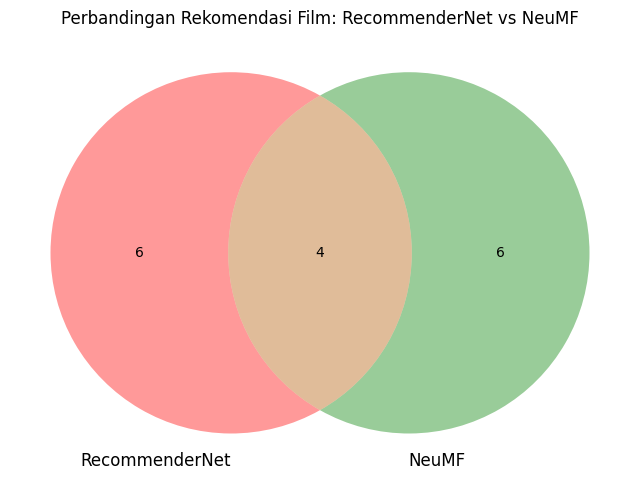

In [28]:
# Ambil Top-10 rekomendasi dari model pertama (RecommenderNet)
top_n_rec_recommender = get_top_n_recommendations(1, model, n=10, use_neumf=False)
recommended_movies_recommender = set(top_n_rec_recommender['title'])

# Ambil Top-10 rekomendasi dari model kedua (NeuMF)
top_n_rec_neumf = get_top_n_recommendations(1, neuMF_model, n=10, use_neumf=True)
recommended_movies_neumf = set(top_n_rec_neumf['title'])

# Membuat Diagram Venn untuk membandingkan rekomendasi kedua model
plt.figure(figsize=(8, 6))
venn2([recommended_movies_recommender, recommended_movies_neumf], 
      set_labels=('RecommenderNet', 'NeuMF'))

plt.title('Perbandingan Rekomendasi Film: RecommenderNet vs NeuMF')
plt.show()

## 8.7. WordCloud

Visualisasi WordCloud yang membandingkan judul film yang direkomendasikan oleh dua model, RecommenderNet dan NeuMF.

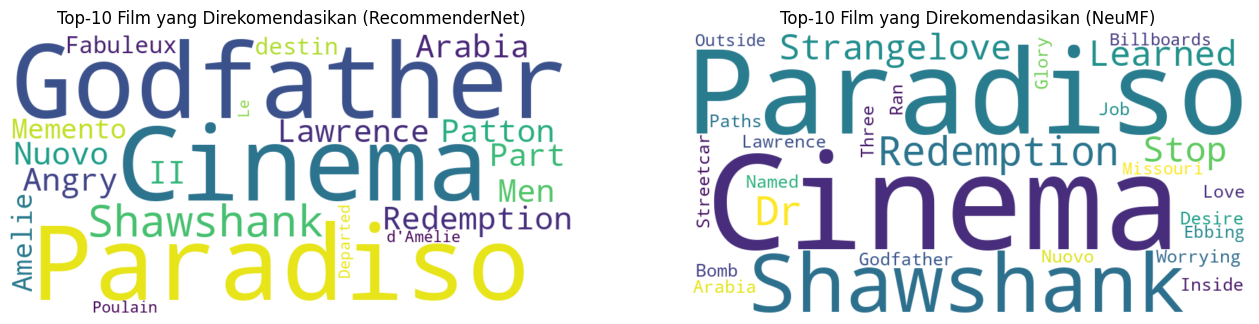

In [29]:
# Gabungkan judul film yang direkomendasikan dari model pertama (RecommenderNet)
top_titles_recommender = top_n_rec_recommender['title'].values
text_recommender = " ".join(top_titles_recommender)

# Buat word cloud untuk model pertama (RecommenderNet)
wordcloud_recommender = WordCloud(width=800, height=400, background_color='white').generate(text_recommender)

# Gabungkan judul film yang direkomendasikan dari model kedua (NeuMF)
top_titles_neumf = top_n_rec_neumf['title'].values
text_neumf = " ".join(top_titles_neumf)

# Buat word cloud untuk model kedua (NeuMF)
wordcloud_neumf = WordCloud(width=800, height=400, background_color='white').generate(text_neumf)

# Membuat figure untuk visualisasi gabungan
plt.figure(figsize=(16, 8))

# Plot WordCloud untuk model pertama (RecommenderNet) di sebelah kiri
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_recommender, interpolation='bilinear')
plt.axis('off')
plt.title('Top-10 Film yang Direkomendasikan (RecommenderNet)')

# Plot WordCloud untuk model kedua (NeuMF) di sebelah kanan
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neumf, interpolation='bilinear')
plt.axis('off')
plt.title('Top-10 Film yang Direkomendasikan (NeuMF)')

# Menampilkan plot
plt.show()